# Multi-agent model training using Nocturne



## Creating the environment

In [1]:
import os
import torch
from nocturne.envs.wrappers import create_env
import yaml
import numpy as np
import re

import tqdm
from IPython import display

import matplotlib.pyplot as plt

/Users/vmoens/venv/nocturne/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf


# env = create_env(cfg)

In [3]:
frames_per_batch=80*20
max_frames_per_traj=80*20
num_lstm_layers = 2
n_optim_per_batch = 10

device="cpu"

total_frames=5000000

## Environment wrapper in torchrl

In [6]:
from torchrl.envs.libs.gym import GymWrapper
from torchrl.envs import TransformedEnv, TensorDictPrimer
from torchrl.data import NdUnboundedContinuousTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec, TensorDict
from nocturne import Action

class NocturneWrapper(GymWrapper):
    def __init__(self, cfg):
        batch_size = cfg['max_num_vehicles']
        super().__init__(create_env(cfg), batch_size=[batch_size])
        self.action_spec = NdUnboundedContinuousTensorSpec(3, device=self.device)
        # action_spec = {str(i): self.action_spec for i in range(batch_size)}
        # self.action_spec = CompositeSpec(**action_spec)
        # reward_spec = {str(i): UnboundedContinuousTensorSpec() for i in range(batch_size)}
        # self.reward_spec = CompositeSpec(**reward_spec)

    def read_action(self, action):
        action = action.detach()
        env_moved_ids = [veh.id for veh in self._env.scenario.getObjectsThatMoved()]
        return {i: Action(acceleration=float(_action[0]), steering=float(_action[1]), head_angle=float(_action[2])) for i, _action in enumerate(action) if i in env_moved_ids}

    def read_reward(self, toral_reward, step_reward):
        for i in range(self.batch_size[0]):
            toral_reward[i] += step_reward.get(i, 0.0)
        return toral_reward

    def read_done(self, done):
        done_out = torch.zeros(self.batch_size, device=self.device, dtype=torch.bool)
        for i in range(self.batch_size[0]):
            done_out[i] = done.get(i, False)
        return done_out, False

    def read_obs(self, obs, dtype=None):
        max_items = self.batch_size[0]
        z = None
        for _array in obs.values():
            if _array is not None:
                z = _array * 0
                break
        if z is None:
            raise RuntimeError("no data")
        array = [obs[i] if i in obs else z for i in range(max_items)]
        array = np.array(array)
        if dtype:
            tensor = torch.as_tensor(array, dtype=dtype)
        else:
            tensor = torch.as_tensor(array)
        return {"next_observation": tensor}

    def _reset(self, tensordict):
        out = super()._reset()
        while not out["next_observation"].any():
            out = super()._reset()
        return out

## Policy and value model

In [7]:
from torch.nn import LSTM, LSTMCell, GRU
from torchrl.modules import MLP
from torchrl.envs.utils import set_exploration_mode
from torch import nn
from torchrl.envs import EnvCreator

with initialize(version_base=None, config_path="../../../Repos/RL/nocturne/cfgs/"):
    cfg = compose(config_name="config.yaml")

num_lstm_layers = 2
def make_env(cfg=cfg):

    env = NocturneWrapper(cfg)
    hidden_names = [*[f"next_hidden{j}" for j in range(num_lstm_layers)]]
    hidden_values = [NdUnboundedContinuousTensorSpec(512) for _ in range(num_lstm_layers)]
    hidden_specs = {n: val for n, val in zip(hidden_names, hidden_values)}
    env = TransformedEnv(env, TensorDictPrimer(**hidden_specs))
    return env
make_env = EnvCreator(make_env)

In [8]:
class PolicyNet(nn.Module):
    def __init__(self, out_features, device="cpu", num_lstm_layers=2):
        super().__init__()
        self.num_lstm_layers = num_lstm_layers
        self.lstm_states = LSTM(13470, 256, bidirectional=True, num_layers=2, batch_first=False, device=device)
        self.gru_temporal = nn.ModuleList([GRU(512, 512, bidirectional=False, num_layers=1, batch_first=True, device=device) for _ in range(num_lstm_layers)])
        # self.lstm_temporal1 = 
        # self.lstm_temporal2 = GRU(512, 512, bidirectional=False, num_layers=2, batch_first=True, device=device)
        self.net = MLP(out_features=out_features, num_cells=[128, 128], activation_class=nn.ELU)
    
    def forward(self, observation, *hiddens):
        unsqueeze = False
        if observation.ndimension() == 2:
            unsqueeze = True
            # we assume a single time step
            observation = observation.unsqueeze(1)  # time is at dim 1
        embed, _ = self.lstm_states(observation)
        if unsqueeze:
            # hidden has shape [batch x D]
            hiddens = [hidden.unsqueeze(1) for hidden in hiddens]
        else:
            # hidden has shape [batch x time_steps x D]
            # we have one hidden state per time step, we just need one
            hiddens = [hidden[:, -1:] for hidden in hiddens]

        next_hiddens = []
        # all_none = all(_hidden is None for _hidden in hiddens)
        for i in range(self.num_lstm_layers):
            _hiddens = hiddens[i]
            embed, hidden = self.gru_temporal[i](embed, _hiddens.transpose(0, 1))
            # embed is of size batch x time x D
            # hidden is of size 1 x batch x D
            # we can discard hidden, which is equal to embed
            next_hiddens.append(embed)
        
        #     embed = next_hiddens[-2]
        # if not unsqueeze:
        #     next_hiddens = [next_hidden.unflatten(0, shape) for next_hidden in next_hiddens]
        #     embed = embed.unflatten(0, shape)
        
        embed = self.net(embed)
        if unsqueeze:
            embed = embed.squeeze(1)
            next_hiddens = [next_hidden.squeeze(1) for next_hidden in next_hiddens]
        return (embed, *next_hiddens)


### Wrapping networks in tensordict modules

In [9]:
from torchrl.modules import ProbabilisticActor, TensorDictModule, ValueOperator, NormalParamWrapper
from torchrl.modules.distributions import IndependentNormal
env = make_env()

policy_net = NormalParamWrapper(PolicyNet(2 * env.action_spec.shape[-1]), scale_mapping="biased_softplus_0.1")
value_net = PolicyNet(1)

actor = ProbabilisticActor(
    TensorDictModule(
        policy_net, 
         ["observation", *[f"hidden{j}" for j in range(num_lstm_layers)]], 
         ["loc", "scale", *[f"next_hidden{j}" for j in range(num_lstm_layers)]]),
    distribution_class=IndependentNormal,
    dist_param_keys=["loc", "scale"],
    out_key_sample=["action"],
    return_log_prob=True,
)

value = TensorDictModule(
    value_net, 
    in_keys=["observation", *[f"hidden{j}" for j in range(num_lstm_layers)]], 
    out_keys=["state_value", *[f"next_hidden{j}" for j in range(num_lstm_layers)]],
)
actor(env.reset())
value(env.reset())


/Users/vmoens/venv/nocturne/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TensorDict(
    fields={
        done: Tensor(torch.Size([20, 1]), dtype=torch.bool),
        hidden0: Tensor(torch.Size([20, 512]), dtype=torch.float32),
        hidden1: Tensor(torch.Size([20, 512]), dtype=torch.float32),
        next_hidden0: Tensor(torch.Size([20, 512]), dtype=torch.float32),
        next_hidden1: Tensor(torch.Size([20, 512]), dtype=torch.float32),
        observation: Tensor(torch.Size([20, 13470]), dtype=torch.float32),
        state_value: Tensor(torch.Size([20, 1]), dtype=torch.float32)},
    batch_size=torch.Size([20]),
    device=cpu,
    is_shared=False)

## Loss function

In [10]:
from torchrl.objectives import ClipPPOLoss, TDLambdaEstimate

In [11]:
value_estimator = TDLambdaEstimate(0.99, 0.95, value)

In [12]:
loss_module = ClipPPOLoss(actor, value)
optim = torch.optim.Adam(loss_module.parameters(), 5e-3)

## Data collector


In [13]:
from torchrl.collectors import SyncDataCollector

collector = SyncDataCollector(make_env, actor, frames_per_batch=frames_per_batch, max_frames_per_traj=max_frames_per_traj, device=device, total_frames=total_frames, split_trajs=False)

<Figure size 640x480 with 0 Axes>

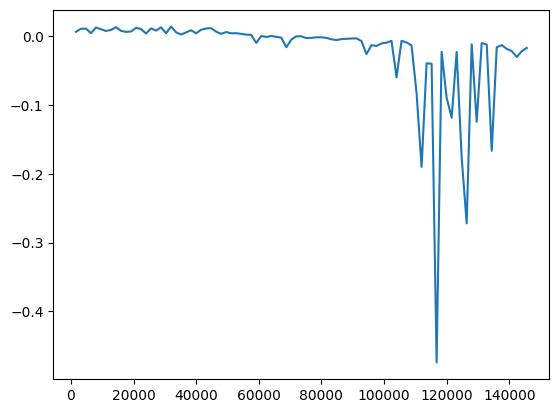

total_reward=-0.0542:   3%|█████                                                                                                                                                           | 160000/5000000 [57:59<24:58:11, 53.84it/s]

In [ ]:
pbar = tqdm.tqdm(total=total_frames)

frames = []
rewards = []
for i, d in enumerate(collector):
    idx = d["observation"].sum(1).any(-1)
    frames.append(d.numel())
    if len(frames) > 1:
        frames[-1] = frames[-2] + frames[-1]
    rewards.append(d['reward'][idx].mean())
    pbar.update(d.numel())
    for j in range(n_optim_per_batch):
        tensordict = value_estimator(d)
        losses = loss_module(tensordict)
        loss = sum([v.mean() for k, v in losses.items() if k.startswith("loss_")])
        loss.backward()
        optim.step()
        optim.zero_grad()
    pbar.set_description(f"total_reward={rewards[-1]: 4.4f}")
    if i % 10 == 0:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.plot(frames, rewards)
        plt.show()
    collector.update_policy_weights_()


In [ ]:
d.shape